# Preamble

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from my_units import *
from scipy.interpolate import griddata
from sky_patch_class import *
from sim_setup_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

HomeDir = '../'
ListDir = HomeDir+'lists/'
ListResDir = ListDir+'sim/'
ListDataChiSq = ListDir+'data_chi_sq/'
FigDir = HomeDir+'figures/'

In [2]:
from IPython.core.display import display, HTML
from IPython.display import display, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

# Functions

## Import simulation results

In [3]:
def fn_import_sim_res(param_space_points, data_file_names, chi_sq_column):
    """
    Imports the simulations and data chi_sq and computes the 50% and 90% CL limits for each parameter space point in the array param_space_points.
    Returns the result as an array of (len(param_space_points), 5), with 3 columns for the parameters, the 4th column for the 50% CL limit and the 5th column for the 90% CL limit.
    """
    limit_array = np.zeros((len(param_space_points), 5))

    for i, p in enumerate(param_space_points):
        limit_array[i, :3] = p.astype(float);    
        sim_chisq = []; data_chisq = []

        for data_file_name in data_file_names:
            sim_file = ListResDir+data_file_name+'_'+p[0]+'_'+p[1]+'_'+p[2]+'_all.csv'
            data_file = ListDataChiSq+data_file_name+'_chisq_'+p[0]+'_'+p[1]+'_'+p[2]+'.csv'

            ### Check that results file exists for both data analysis and simulation
            if (os.path.isfile(sim_file) & os.path.isfile(data_file)):
                df_sim = pd.read_csv(sim_file)
                df_data = pd.read_csv(data_file)

                sim_chisq.append(df_sim[chi_sq_column].to_numpy())
                data_chisq.extend(df_data[chi_sq_column].to_numpy())
                beta_t_val = df_sim['beta_t'].to_numpy()/degree
            else:
                print('Files for parameter space point ', p, ' do not exist.')

        if len(sim_chisq)>0:   
            ### Check that both LMC and SMC have the same number of simulations
            n_sim = len(sim_chisq[0])
            if n_sim == len(sim_chisq[1]):
                print('Parameter space point ', p, ' with ', n_sim, ' simulations.')
            else:
                print('Parameter space point ', p, ' does not have the same n_sim for both LMC and SMC.')

            limit_array[i, 3]  = np.percentile(np.min(np.array(sim_chisq).T, axis=1), 50)/np.min(np.array(data_chisq))
            limit_array[i, 4]  = np.percentile(np.min(np.array(sim_chisq).T, axis=1), 90)/np.min(np.array(data_chisq))
            
    return limit_array

In [4]:
def fn_limit_matrix(limit_array):
    """
    Converts the array with the limit into a matrix for the contour plots in the (f_l, M_l) plane.
    Returns 4 matrices: M_l values, f_l values, 50% CL limit, 90% CL limit
    """
    
    x_list = np.unique(limit_array[:, 0])
    y_list = np.unique(limit_array[:, 2])
    x_matrix, y_matrix = np.meshgrid(x_list, y_list)
    z_CL50, z_CL90 = np.zeros(x_matrix.shape)*np.nan, np.zeros(x_matrix.shape)*np.nan

    for i in range(x_matrix.shape[0]):
        for j in range(x_matrix.shape[1]):
            sel_z_CL50 = limit_array[:, 3][np.where((limit_array[:, 0]==x_matrix[i, j]) & (limit_array[:, 2]==y_matrix[i, j]))]
            sel_z_CL90 = limit_array[:, 4][np.where((limit_array[:, 0]==x_matrix[i, j]) & (limit_array[:, 2]==y_matrix[i, j]))]
            if len(sel_z_CL50) > 0:
                z_CL50[i, j] =  sel_z_CL50
                z_CL90[i, j] =  sel_z_CL90
            else:
                x_matrix[i, j] = np.nan; y_matrix[i, j] = np.nan
                
    return x_matrix, y_matrix, z_CL50, z_CL90

## Sensitivity projections

In [5]:
### SNR = 1 giving the lens subfraction f_l as a function of lens mass for the most compact lenses (min r_l)
### For the velocity template (mu) and acceleration template (alpha).
### For the mu template, we require at least 3 lenses in front of the Magellanic Clouds, using the MW DM distribution in the direction of the clouds.
### For the alpha template, we require at least 3 lenses between us and the stars at Dstars, assuming uniform DM distribution.

def fn_fl_mu_MCs(Ml, vl, Delta_Omega, sigma_mu, Sigma_0, tau):

    n_avg_95CL = 3 ### 5% of a Poisson distribution
    n_lens_LMC = fn_n_lens(MSolar, 1, LMC_sky_patch.distance, LMC_sky_patch.center_l*degree, LMC_sky_patch.center_b*degree, LMC_sky_patch.delta_omega)  
    n_lens_SMC = fn_n_lens(MSolar, 1, SMC_sky_patch.distance, SMC_sky_patch.center_l*degree, SMC_sky_patch.center_b*degree, SMC_sky_patch.delta_omega)  
    
    fl1 = 3/(4**(3/2) * math.pi**(3/4) ) * ( sigma_mu /(GN*vl*Sigma_0) )**(3/2) / (Ml**(1/2) * RhoDMG * Delta_Omega)
    fl2 = 3/4**3 * (tau * sigma_mu / GN)**3 / (Ml**2 * Sigma_0**(3/2) * RhoDMG * Delta_Omega)
    fl3 = n_avg_95CL*Ml/MSolar/(n_lens_LMC + n_lens_SMC)
    
    return max(fl1, fl2, fl3)


def fn_fl_alpha(Ml, vl, Delta_Omega, sigma_alpha, Sigma_0, tau, Dstar):
    
    fl1 = 3/(8 * math.pi ) * ( sigma_alpha /(GN * vl**2 * RhoDMG * Delta_Omega * Sigma_0**(3/2)) ) 
    fl2 = 3/8**3 * (tau**2 * sigma_alpha / GN)**3 / (Ml**2 * Sigma_0**(3/2) * RhoDMG * Delta_Omega)
    fl3 = 9/Dstar**3 * Ml/(Delta_Omega * RhoDMG)
    
    return max(fl1, fl2, fl3)

In [6]:
### SNR = 1 giving the lens subfraction f_l as a function of lens mass for a fixed r_l value

def fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Omega, sigma_mu, Sigma_0):
    
    n_avg_95CL = 3 ### 5% of a Poisson distribution
    n_lens_LMC = fn_n_lens(MSolar, 1, LMC_sky_patch.distance, LMC_sky_patch.center_l*degree, LMC_sky_patch.center_b*degree, LMC_sky_patch.delta_omega)  
    n_lens_SMC = fn_n_lens(MSolar, 1, SMC_sky_patch.distance, SMC_sky_patch.center_l*degree, SMC_sky_patch.center_b*degree, SMC_sky_patch.delta_omega)  
    
    fl1 = (rl * sigma_mu / (4 * GN * vl * Sigma_0**(1/2)) )**3 / Ml**2 * 3 / (RhoDMG * Delta_Omega)
    fl2 = n_avg_95CL*Ml/MSolar/(n_lens_LMC + n_lens_SMC)
   
    return max(fl1, fl2)

def fn_fl_alpha_fix_rl(Ml, rl, vl, Delta_Omega, sigma_alpha, Sigma_0, Dstar):
        
    fl1 = 3*(rl**2 * sigma_alpha / (8 * GN * vl**2 * Sigma_0**(1/2)) )**3 / ( Ml**2 * RhoDMG * Delta_Omega )
    fl2 = 9/Dstar**3 * Ml/(Delta_Omega * RhoDMG)
   
    return max(fl1, fl2)

In [7]:
def fn_fl_min(Ml, Delta_Omega, Dstar):
    """
    Minimum value of lens subfraction f_l as a function of lens mass M_l that gives at least 3 lenses within a distance Dstar and solid angle Delta_Omega.
    Assuming uniform DM distribution.
    """    
    return 3/Dstar**3 * 3*Ml/(Delta_Omega * RhoDMG)

def fn_fl_min_MCs(Ml):
    """
    Minimum value of lens subfraction f_l as a function of lens mass M_l that gives at least 3 lenses in front of the Magellanic Clouds.
    """
    n_avg_95CL = 3 ### 5% of a Poisson distribution
    n_lens_LMC = fn_n_lens(MSolar, 1, LMC_sky_patch.distance, LMC_sky_patch.center_l*degree, LMC_sky_patch.center_b*degree, LMC_sky_patch.delta_omega)  
    n_lens_SMC = fn_n_lens(MSolar, 1, SMC_sky_patch.distance, SMC_sky_patch.center_l*degree, SMC_sky_patch.center_b*degree, SMC_sky_patch.delta_omega)  
    
    return n_avg_95CL*Ml/MSolar/(n_lens_LMC + n_lens_SMC)

def fn_fl_max(Ml, vl, Delta_Omega, Sigma_0, tau):
    """
    Value of f_l that gives the transition between the two lower bounds on the minimum r_l
    """
    return 1/(vl*tau*(math.pi*Sigma_0)**(1/2))**3 * 3*Ml/(Delta_Omega * RhoDMG)

In [8]:
### Values of min r_l and min D_l

def fn_rl_min(vl, tau, Ml, fl, Delta_Omega, Sigma_0):
    
    rl1 = vl*tau
    rl2 = 1/np.sqrt(math.pi*Sigma_0)*( 3*Ml / (Delta_Omega * fl * RhoDMG) )**(1/3)
    
    return max(rl1, rl2)

def fn_Dl_min( Ml, fl, Delta_Omega, Sigma_0):
    
    return ( 3*Ml / (Delta_Omega * fl * RhoDMG) )**(1/3)

# DR3 limit plots and projections

## Import simulation results

In [9]:
data_file_names = ['LMC_disc_5', 'SMC_disc_4'] 
chi_sq_column = 'min_chi_sq' ### Data frame column with the chi_sq value

In [10]:
LMC_sky_patch = sky_patch(81.28, -69.78, 5*degree, 50*kpc, 'LMC_disc_5', np.array([1.871, 0.391]), pm_esc = 0.2, sigma_pm = 0.125)
SMC_sky_patch = sky_patch(12.80, -73.15, 4*degree, 60*kpc, 'SMC_disc_4', np.array([0.686, -1.237]), pm_esc = 0.2, sigma_pm = 0.105)

In [11]:
### DR3 limit for r_l = 1 pc
param_space_points_30 = np.loadtxt(ListDir+'param_space_points_30.txt', dtype='str')
print(len(param_space_points_30))

limit_array_30 = fn_import_sim_res(param_space_points_30, data_file_names, chi_sq_column)

limit_matrix_30 = fn_limit_matrix(limit_array_30)
limit_matrix_30

48
Parameter space point  ['72' '30' '38']  with  150  simulations.
Parameter space point  ['72' '30' '40']  with  150  simulations.
Parameter space point  ['74' '30' '34']  with  150  simulations.
Parameter space point  ['74' '30' '36']  with  150  simulations.
Parameter space point  ['74' '30' '38']  with  150  simulations.
Parameter space point  ['74' '30' '40']  with  150  simulations.
Parameter space point  ['76' '30' '30']  with  150  simulations.
Parameter space point  ['76' '30' '32']  with  150  simulations.
Parameter space point  ['76' '30' '34']  with  150  simulations.
Parameter space point  ['76' '30' '36']  with  150  simulations.
Parameter space point  ['76' '30' '38']  with  150  simulations.
Parameter space point  ['76' '30' '40']  with  150  simulations.
Parameter space point  ['78' '30' '30']  with  150  simulations.
Parameter space point  ['78' '30' '32']  with  150  simulations.
Parameter space point  ['78' '30' '34']  with  150  simulations.
Parameter space point 

(array([[nan, nan, nan, nan, 80., 82., 84., 86., nan, nan],
        [nan, nan, 76., 78., 80., 82., 84., 86., 88., 90.],
        [nan, nan, 76., 78., 80., 82., 84., 86., 88., 90.],
        [nan, 74., 76., 78., 80., 82., 84., 86., 88., 90.],
        [nan, 74., 76., 78., 80., 82., 84., 86., 88., 90.],
        [72., 74., 76., 78., nan, nan, nan, 86., nan, 90.],
        [72., 74., 76., 78., nan, nan, nan, nan, nan, nan]]),
 array([[nan, nan, nan, nan, 28., 28., 28., 28., nan, nan],
        [nan, nan, 30., 30., 30., 30., 30., 30., 30., 30.],
        [nan, nan, 32., 32., 32., 32., 32., 32., 32., 32.],
        [nan, 34., 34., 34., 34., 34., 34., 34., 34., 34.],
        [nan, 36., 36., 36., 36., 36., 36., 36., 36., 36.],
        [38., 38., 38., 38., nan, nan, nan, 38., nan, 38.],
        [40., 40., 40., 40., nan, nan, nan, nan, nan, nan]]),
 array([[       nan,        nan,        nan,        nan, 0.94811978, 0.90555145, 0.92642818, 0.88368408,        nan,        nan],
        [       nan,      

In [12]:
### DR3 limit for r_l = 0.001 pc
param_space_points_00 = np.loadtxt(ListDir+'param_space_points_00.txt', dtype='str')
print(len(param_space_points_00))

limit_array_00 = fn_import_sim_res(param_space_points_00, data_file_names, chi_sq_column)

limit_matrix_00 = fn_limit_matrix(limit_array_00)
limit_matrix_00

85
Parameter space point  ['60' '00' '32']  with  150  simulations.
Parameter space point  ['60' '00' '34']  with  150  simulations.
Parameter space point  ['60' '00' '36']  with  150  simulations.
Parameter space point  ['60' '00' '38']  with  150  simulations.
Parameter space point  ['60' '00' '40']  with  150  simulations.
Parameter space point  ['62' '00' '32']  with  150  simulations.
Parameter space point  ['62' '00' '34']  with  150  simulations.
Parameter space point  ['62' '00' '36']  with  150  simulations.
Parameter space point  ['62' '00' '38']  with  150  simulations.
Parameter space point  ['62' '00' '40']  with  150  simulations.
Parameter space point  ['64' '00' '32']  with  150  simulations.
Parameter space point  ['64' '00' '34']  with  150  simulations.
Parameter space point  ['64' '00' '36']  with  150  simulations.
Parameter space point  ['64' '00' '38']  with  150  simulations.
Parameter space point  ['64' '00' '40']  with  150  simulations.
Parameter space point 

(array([[nan, nan, nan, nan, nan, nan, nan, 74., 76., 78., 80., 82., nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, 72., 74., 76., 78., 80., 82., 84., 86., 88., nan],
        [nan, nan, nan, 66., 68., 70., 72., 74., 76., 78., 80., 82., 84., 86., 88., 90.],
        [60., 62., 64., 66., 68., 70., 72., 74., 76., 78., 80., 82., 84., 86., 88., 90.],
        [60., 62., 64., 66., 68., 70., 72., 74., 76., 78., 80., 82., 84., 86., 88., 90.],
        [60., 62., 64., 66., 68., 70., 72., 74., nan, nan, 80., 82., 84., 86., 88., 90.],
        [60., 62., 64., 66., 68., 70., nan, nan, nan, nan, nan, nan, nan, nan, nan, 90.],
        [60., 62., 64., 66., nan, 70., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]),
 array([[nan, nan, nan, nan, nan, nan, nan, 26., 26., 26., 26., 26., nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, 28., 28., 28., 28., 28., 28., 28., 28., 28., nan],
        [nan, nan, nan, 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.],
        

In [213]:
limit_matrix_00[2][:, 3]

array([       nan,        nan, 0.96466876, 1.02183222, 1.13836464, 1.22595661, 1.28733679, 1.47333656])

In [212]:
limit_matrix_00[2][:, 2]

array([       nan,        nan,        nan, 0.9724661 , 1.0721775 , 1.14800846, 1.32722649, 1.4073452 ])

In [53]:
limit_matrix_00[1][:, 2]

array([nan, nan, nan, 32., 34., 36., 38., 40.])

In [13]:
### Importing the DR2 results

dr2_Ml_list = np.array([69, 72, 75, 78, 81, 84, 87, 90]);
dr2_fl_list = np.array([30, 32, 34, 36, 38, 40, 42]);
dr2_x_matrix, dr2_y_matrix = np.meshgrid(dr2_Ml_list, dr2_fl_list)

dr2_30_CL50 = np.loadtxt(ListDir+'/lists_dr2_limit/MlOmegal_30_50CL_trNFW.txt').astype(float)
dr2_30_CL90 = np.loadtxt(ListDir+'/lists_dr2_limit/MlOmegal_30_90CL_trNFW.txt').astype(float)
dr2_00_CL50 = np.loadtxt(ListDir+'/lists_dr2_limit/MlOmegal_00_50CL_trNFW.txt').astype(float)
dr2_00_CL90 = np.loadtxt(ListDir+'/lists_dr2_limit/MlOmegal_00_90CL_trNFW.txt').astype(float)

## Plot the limit only

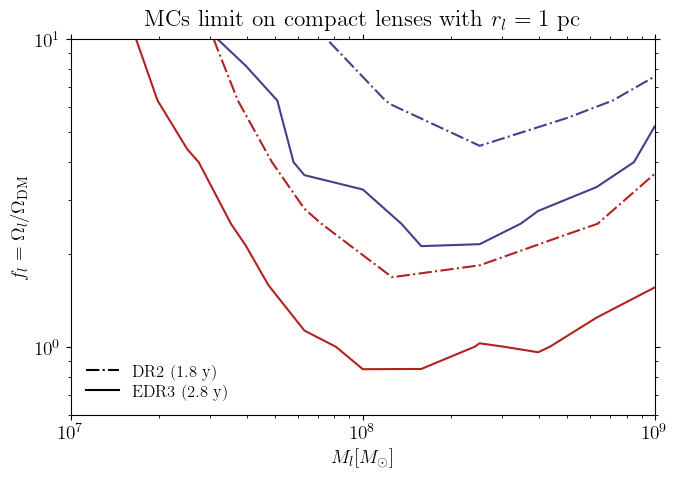

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_30_CL90.T, levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_30_CL50.T, levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, limit_matrix_30[0]/10), np.power(10, (limit_matrix_30[1]-30)/10), limit_matrix_30[3], levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[1])
ax.contour(np.power(10, limit_matrix_30[0]/10), np.power(10, (limit_matrix_30[1]-30)/10), limit_matrix_30[2], levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[1])

p = [plt.plot([0, 10], [0, 0], linestyle=liestyle_list[i], linewidth=1.5, color='k')[0] for i in range(2)]
ax.legend(p, [r'DR2 (1.8 y)', r'EDR3 (2.8 y)', ], loc='lower left', frameon=False, labelspacing=0.2, fontsize=12);
[p[i].set_visible(False) for i in range(len(p))]


ax.set_xscale('log'); ax.set_yscale('log');
# Set ticks on both sides of axes on
ax.minorticks_on()
ax.tick_params(axis='both', which='both', bottom=True, top=True, labelbottom=True, labeltop=False, left=True, right=True, labelleft=True, labelright=False)

ax.set_title(r'MCs limit on compact lenses with $r_l = 1\ \mathrm{pc}$', pad=10);
ax.set_xlabel(r'$M_{l} [M_{\odot}]$')
ax.set_ylabel(r'$f_l = \Omega_{l}/\Omega_\mathrm{DM}$')
ax.axis([1*math.pow(10, 7), math.pow(10, 9), 0.7, 16]);
ax.set_ylim(0.6, 10)
#ax.yaxis.tick_right()
fig.tight_layout()
#fig.savefig(FigDir+'Compact_lens_limit_DR2_EDR3.pdf')

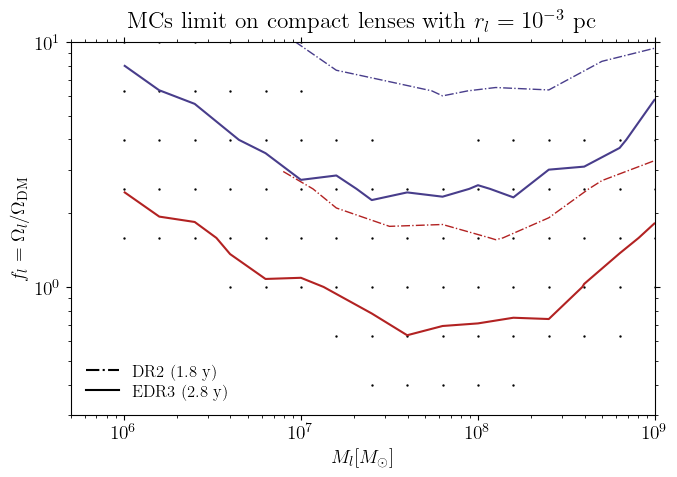

In [215]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_00_CL90.T, levels=[1], colors=colorlist[0], linewidths = 1, linestyles=liestyle_list[0])
ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_00_CL50.T, levels=[1], colors=colorlist[1], linewidths = 1, linestyles=liestyle_list[0])
ax.contour(np.power(10, limit_matrix_00[0]/10), np.power(10, (limit_matrix_00[1]-30)/10), limit_matrix_00[3], levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[1])
ax.contour(np.power(10, limit_matrix_00[0]/10), np.power(10, (limit_matrix_00[1]-30)/10), limit_matrix_00[2], levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[1])

ax.scatter(np.power(10, limit_matrix_00[0]/10), np.power(10, (limit_matrix_00[1]-30)/10), s=0.5, c='k')

p = [plt.plot([0, 10], [0, 0], linestyle=liestyle_list[i], linewidth=1.5, color='k')[0] for i in range(2)]
ax.legend(p, [r'DR2 (1.8 y)', r'EDR3 (2.8 y)', ], loc='lower left', frameon=False, labelspacing=0.2, fontsize=12);
[p[i].set_visible(False) for i in range(len(p))]


ax.set_xscale('log'); ax.set_yscale('log');
# Set ticks on both sides of axes on
ax.minorticks_on()
ax.tick_params(axis='both', which='both', bottom=True, top=True, labelbottom=True, labeltop=False, left=True, right=True, labelleft=True, labelright=False)

ax.set_title(r'MCs limit on compact lenses with $r_l = 10^{-3}\ \mathrm{pc}$', pad=10);
ax.set_xlabel(r'$M_{l} [M_{\odot}]$')
ax.set_ylabel(r'$f_l = \Omega_{l}/\Omega_\mathrm{DM}$')
ax.axis([0.5*math.pow(10, 6), math.pow(10, 9), 0.3, 10]);
#ax.set_ylim(0.6, 10)
#ax.yaxis.tick_right()
fig.tight_layout()
#fig.savefig(FigDir+'Compact_lens_limit_DR2_EDR3.pdf')

## Proper motion template limits and projections

### Compact lenses (rl = 1 pc)

In [17]:
### Parameters for the LMC now
Delta_Om_LMC = LMC_sky_patch.delta_omega # solid angle
Sigma_0_LMC = 12.7*10**6/LMC_sky_patch.delta_omega # angular number density
sigma_mu_LMC_DR2 = 1.75*masy # value chosen to anchor the "expected" DR2 limit to the observed 50% CL limit
avg_dr2_eff_err = 1.54*masy
look_elswhere_factor = sigma_mu_LMC_DR2/avg_dr2_eff_err
sigma_mu_LMC_eom = look_elswhere_factor*0.2*masy # max(sigma_mu_LMC_DR2/(10*12/22)**(3/2), 0.2*masy)

vl = np.sqrt(math.pi/2)*166*1000*Meter/Second

print(Sigma_0_LMC/1E8, Delta_Om_LMC, sigma_mu_LMC_eom/masy)
print('Look elshwehere effect factor = ', look_elswhere_factor)

5.311714618181911 0.023909417039326832 0.2272727272727273
Look elshwehere effect factor =  1.1363636363636365


In [26]:
rl = 1*pc

Ml_30_list = np.logspace(6, 9, num = 200)*MSolar
fl_30_list_LMC_DR2 = np.array([fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Om_LMC, sigma_mu_LMC_DR2, Sigma_0_LMC) for Ml in Ml_30_list])
fl_30_list_LMC_eDR3 = np.array([fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Om_LMC, sigma_mu_LMC_DR2/(34/22)**(3/2), Sigma_0_LMC) for Ml in Ml_30_list])
fl_30_list_LMC_eom = np.array([fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Om_LMC, sigma_mu_LMC_eom, Sigma_0_LMC) for Ml in Ml_30_list])

In [27]:
err_list_1 = np.zeros(len(fl_30_list_LMC_DR2))*np.nan
err_list_1[np.argmin(np.abs(Ml_30_list/MSolar - 5E7) )] = 3E7 

err_list_2 = np.zeros(len(fl_30_list_LMC_eDR3))*np.nan
err_list_2[np.argmin(np.abs(Ml_30_list/MSolar - 3.5E7) )] = 2.9E7

<ipython-input-43-48e520e7dbaa>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


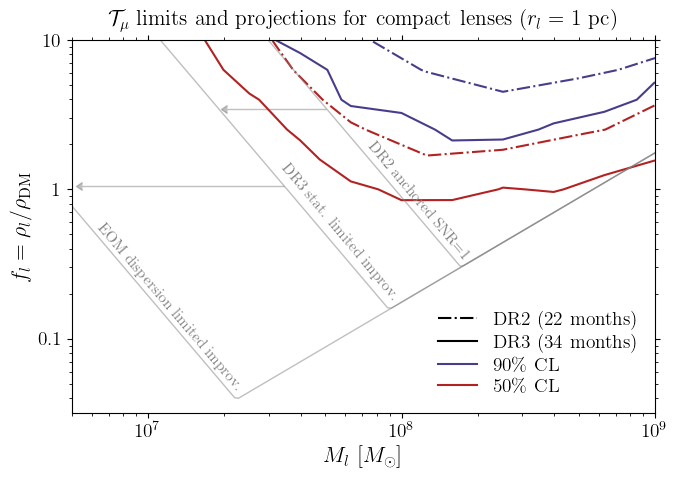

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid', ':']

ax.minorticks_on()
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both');

ax.errorbar(Ml_30_list/MSolar, fl_30_list_LMC_DR2, xerr=err_list_1, xuplims=True, 
            c='grey', linewidth = 1, alpha=0.5, linestyle='solid')
ax.errorbar(Ml_30_list/MSolar, fl_30_list_LMC_eDR3, xerr=err_list_2, xuplims=True, 
            c='grey', linewidth = 1, alpha=0.5, linestyle='solid')
ax.plot(Ml_30_list/MSolar, fl_30_list_LMC_eom, c='grey', linewidth = 1, alpha=0.5, linestyle=liestyle_list[1])

ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_30_CL90.T, levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_30_CL50.T, levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, limit_matrix_30[0]/10), np.power(10, (limit_matrix_30[1]-30)/10), limit_matrix_30[3], levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[1])
ax.contour(np.power(10, limit_matrix_30[0]/10), np.power(10, (limit_matrix_30[1]-30)/10), limit_matrix_30[2], levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[1])

p = ([plt.plot([0, 10], [0, 0], linestyle=liestyle_list[i], linewidth=1.5, color='k')[0] for i in range(2)] + 
     [plt.plot([0, 10], [0, 0], linestyle=liestyle_list[1], linewidth=1.5, color=colorlist[i])[0] for i in range(2)] )
ax.legend(p, [r'DR2 (22 months)', r'DR3 (34 months)', r'$90\%$ CL', r'$50\%$ CL'], loc='lower right', frameon=False, labelspacing=0.2, fontsize=14);
[p[i].set_visible(False) for i in range(len(p))]

ax.set_title(r'$\mathcal{T}_\mu$ limits and projections for compact lenses ($r_l = 1\ \mathrm{pc}$) ', pad=10, fontsize=15.5);

ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(5*10**6, 10**9); ax.set_ylim(10**(-1.5), 10); 
ax.set_xlabel(r'$M_l\ [M_\odot]$ ', fontsize=16); 
#ax.set_ylabel(r'$f_l = \Omega_l/\Omega_\mathrm{DM}$ ', fontsize=16);
ax.set_ylabel(r'$f_l = \rho_l/\rho_\mathrm{DM}$ ', fontsize=16);
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[2] = '$\\mathdefault{0.1}$'; labels[3] = '$\\mathdefault{1}$'; labels[4] = '$\\mathdefault{10}$'
ax.set_yticklabels(labels)

ax.text(7.15E7, 0.33, r'DR2 anchored SNR=1', rotation=-50,  c='grey', fontsize=11);
ax.text(3.3E7, 0.18, r'DR3 stat. limited improv.', rotation=-50,  c='grey', fontsize=11);
ax.text(6.2E6, 0.045, r'EOM dispersion limited improv.', rotation=-49.5,  c='grey', fontsize=11);

fig.tight_layout()
fig.savefig(FigDir+'Taumu_compact_v1.pdf')

### Point like lenses (rl = 0.001 pc)

In [45]:
### Parameters for the LMC now
Delta_Om_LMC = LMC_sky_patch.delta_omega # solid angle
Sigma_0_LMC = 12.7*10**6/LMC_sky_patch.delta_omega # angular number density
sigma_mu_LMC_DR2 = 6.27*masy #9*masy # value chosen to anchor the "expected" DR2 limit to the observed 50% CL limit
avg_dr2_eff_err = 1.54*masy
look_elswhere_factor = sigma_mu_LMC_DR2/avg_dr2_eff_err
sigma_mu_LMC_eom = look_elswhere_factor*0.2*masy # max(sigma_mu_LMC_DR2/(10*12/22)**(3/2), 0.2*masy)

vl = np.sqrt(math.pi/2)*166*1000*Meter/Second

print(Sigma_0_LMC/1E8, Delta_Om_LMC, sigma_mu_LMC_eom/masy)
print('Look elshwehere effect factor = ', look_elswhere_factor)

5.311714618181911 0.023909417039326832 0.8142857142857143
Look elshwehere effect factor =  4.071428571428571


In [46]:
rl = 0.001*pc ### it is smaller than the minimum r_l for the LMC density of stars
tau_DR2 = 22/12*Year; tau_EDR3 = 34/12*Year; tau_eom = 10*Year

Ml_00_list = np.logspace(5, 9, num = 300)*MSolar
#fl_00_list_LMC_DR2 = np.array([max(fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Om_LMC, sigma_mu_LMC_DR2, Sigma_0_LMC), 
#                                   fn_fl_mu_MCs(Ml, vl, Delta_Om_LMC, sigma_mu_LMC_DR2, Sigma_0_LMC, tau_DR2)) for Ml in Ml_00_list])
#fl_00_list_LMC_eDR3 = np.array([max(fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Om_LMC, sigma_mu_LMC_DR2/(34/22)**(3/2), Sigma_0_LMC),
#                                    fn_fl_mu_MCs(Ml, vl, Delta_Om_LMC, sigma_mu_LMC_DR2/(tau_EDR3/tau_DR2)**(3/2), Sigma_0_LMC, tau_EDR3)) for Ml in Ml_00_list])
#fl_00_list_LMC_eom = np.array([max(fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Om_LMC, sigma_mu_LMC_eom, Sigma_0_LMC), 
#                                   fn_fl_mu_MCs(Ml, vl, Delta_Om_LMC, sigma_mu_LMC_eom, Sigma_0_LMC, tau_eom)) for Ml in Ml_00_list])
fl_00_list_LMC_DR2 = np.array([fn_fl_mu_MCs(Ml, vl, Delta_Om_LMC, sigma_mu_LMC_DR2, Sigma_0_LMC, tau_DR2) for Ml in Ml_00_list])
fl_00_list_LMC_eDR3 = np.array([fn_fl_mu_MCs(Ml, vl, Delta_Om_LMC, sigma_mu_LMC_DR2/(tau_EDR3/tau_DR2)**(3/2), Sigma_0_LMC, tau_EDR3) for Ml in Ml_00_list])
fl_00_list_LMC_eom = np.array([fn_fl_mu_MCs(Ml, vl, Delta_Om_LMC, sigma_mu_LMC_eom, Sigma_0_LMC, tau_eom) for Ml in Ml_00_list])

In [51]:
err_list_1 = np.zeros(len(fl_00_list_LMC_DR2))*np.nan
err_list_1[np.argmin(np.abs(Ml_00_list/MSolar - 4E6) )] = 2.3

err_list_2 = np.zeros(len(fl_00_list_LMC_DR2))*np.nan
err_list_2[np.argmin(np.abs(Ml_00_list/MSolar - 2E6) )] = 1.9

<ipython-input-65-be528c52e7ee>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


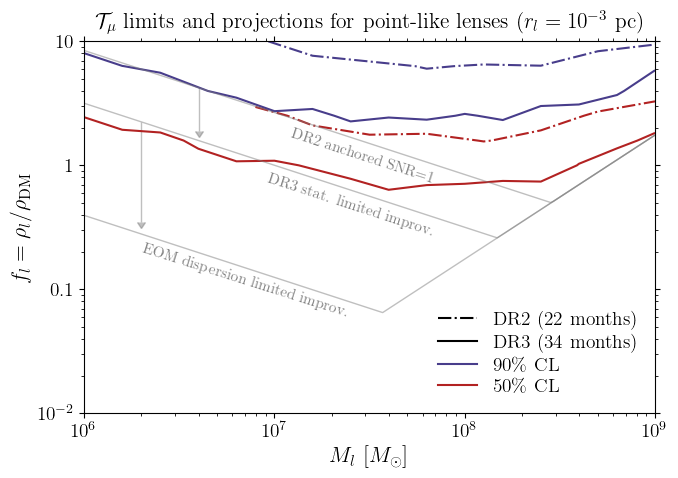

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid', ':']

ax.minorticks_on()
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both');

#ax.plot(Ml_00_list/MSolar, fl_00_list_LMC_DR2, c='grey', linewidth = 1, alpha=0.5, linestyle='solid')
ax.errorbar(Ml_00_list/MSolar, fl_00_list_LMC_DR2, yerr=err_list_1, uplims=True, 
            c='grey', linewidth = 1, alpha=0.5, linestyle='solid')
#ax.plot(Ml_00_list/MSolar, fl_00_list_LMC_eDR3, c='grey', linewidth = 1, alpha=0.5, linestyle='solid')
ax.errorbar(Ml_00_list/MSolar, fl_00_list_LMC_eDR3, yerr=err_list_2, uplims=True, 
            c='grey', linewidth = 1, alpha=0.5, linestyle='solid')
ax.plot(Ml_00_list/MSolar, fl_00_list_LMC_eom, c='grey', linewidth = 1, alpha=0.5, linestyle='solid')

ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_00_CL90.T, levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_00_CL50.T, levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, limit_matrix_00[0]/10), np.power(10, (limit_matrix_00[1]-30)/10), limit_matrix_00[3], levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[1])
ax.contour(np.power(10, limit_matrix_00[0]/10), np.power(10, (limit_matrix_00[1]-30)/10), limit_matrix_00[2], levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[1])

p = ([plt.plot([0, 10], [0, 0], linestyle=liestyle_list[i], linewidth=1.5, color='k')[0] for i in range(2)] + 
     [plt.plot([0, 10], [0, 0], linestyle=liestyle_list[1], linewidth=1.5, color=colorlist[i])[0] for i in range(2)] )
ax.legend(p, [r'DR2 (22 months)', r'DR3 (34 months)', r'$90\%$ CL', r'$50\%$ CL'], loc='lower right', frameon=False, labelspacing=0.2, fontsize=14);
[p[i].set_visible(False) for i in range(len(p))]


ax.set_title(r'$\mathcal{T}_\mu$ limits and projections for point-like lenses ($r_l = 10^{-3}\ \mathrm{pc}$) ', pad=10, fontsize=15.5);

ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(10**6, 10**9); ax.set_ylim(10**(-2), 10); 
ax.set_xlabel(r'$M_l\ [M_\odot]$ ', fontsize=16); 
#ax.set_ylabel(r'$f_l = \Omega_l/\Omega_\mathrm{DM}$ ', fontsize=16);
ax.set_ylabel(r'$f_l = \rho_l/\rho_\mathrm{DM}$ ', fontsize=16);

ax.text(1.2E7, 0.7, r'DR2 anchored SNR=1', rotation=-18,  c='grey', fontsize=11);
ax.text(9E6, 0.27, r'DR3 stat. limited improv.', rotation=-18,  c='grey', fontsize=11);
ax.text(2E6, 0.06, r'EOM dispersion limited improv.', rotation=-17.5,  c='grey', fontsize=11);

fig.tight_layout()

labels = [item.get_text() for item in ax.get_yticklabels()]
labels[2] = '$\\mathdefault{0.1}$'; labels[3] = '$\\mathdefault{1}$'; labels[4] = '$\\mathdefault{10}$'
ax.set_yticklabels(labels);

fig.savefig(FigDir+'Taumu_pointlike_v1.pdf')

## Proper motion and acceleration template projections

In [7]:
LMC_sky_patch = sky_patch(81.28, -69.78, 5*degree, 50*kpc, 'LMC_disc_5', np.array([1.871, 0.391]), pm_esc = 0.2, sigma_pm = 0.125)
SMC_sky_patch = sky_patch(12.80, -73.15, 4*degree, 60*kpc, 'SMC_disc_4', np.array([0.686, -1.237]), pm_esc = 0.2, sigma_pm = 0.105)

In [10]:
tau_eom = 10*Year
f_obs = 14/Year
vl = np.sqrt(math.pi/2)*166*1000*Meter/Second
rl = 1*pc

### Parameters for the LMC after 10 years of Gaia
Delta_Om_LMC = LMC_sky_patch.delta_omega
Sigma_0_LMC = 12.7*10**6/LMC_sky_patch.delta_omega
sigma_mu_LMC_eom = 0.2*masy

### Parameters for the Disk stars after 10 years of Gaia
Delta_Om_disk = 0.2
Sigma_0_disk = 4.5*10**9
D_disk = 3*kpc
sigma_th_disk_eom = 200*muas #74*muas
sigma_alpha_disk = np.sqrt(720)*sigma_th_disk_eom/(tau_eom**(5/2)*f_obs**(1/2)); 
sigma_alpha_hacky_disk = sigma_alpha_disk*66
print(sigma_alpha_disk/muasyy, sigma_alpha_hacky_disk/muasyy)

4.535573676110727 299.34786262330795


In [11]:
Ml_list = np.logspace(2, 9, num = 500)*MSolar
fl_list_LMC_eom = np.array([fn_fl_mu_MCs(Ml, vl, Delta_Om_LMC, sigma_mu_LMC_eom, Sigma_0_LMC, tau_eom) for Ml in Ml_list])
fl_min_list_LMC = np.array([fn_fl_min_MCs(Ml) for Ml in Ml_list])
fl_fix_rl_list_LMC_eom = np.array([fn_fl_mu_fix_rl(Ml, rl, vl, Delta_Om_LMC, sigma_mu_LMC_eom, Sigma_0_LMC) for Ml in Ml_list])

In [12]:
Ml_list_disk = np.logspace(-1, 7, num = 500)*MSolar
fl_list_disk_eom = np.array([fn_fl_alpha(Ml, vl, Delta_Om_disk, sigma_alpha_disk, Sigma_0_disk, tau_eom, D_disk) for Ml in Ml_list_disk])
fl_list_disk_hacky_eom = np.array([fn_fl_alpha(Ml, vl, Delta_Om_disk, sigma_alpha_hacky_disk, Sigma_0_disk, tau_eom, D_disk) for Ml in Ml_list_disk])
fl_max_list_disk_eom = np.array([fn_fl_max(Ml, vl, Delta_Om_disk, Sigma_0_disk, tau_eom) for Ml in Ml_list_disk])
fl_min_list_disk = np.array([fn_fl_min(Ml, Delta_Om_disk, D_disk) for Ml in Ml_list_disk])

In [13]:
Ml_list_rlmin = np.logspace(-1, 7, num = 500)*MSolar
fl_list_disk_eom = np.array([ fn_fl_alpha(Ml, vl, Delta_Om_disk, sigma_alpha_disk, Sigma_0_disk, tau_eom, D_disk) for Ml in Ml_list_disk])

In [14]:
Ml_list_rlmin = np.logspace(-1, 7, num = 50)*MSolar
fl_list_rlmin = np.logspace(-4, 0, num = 50)

Ml_matrix, fl_matrix = np.meshgrid(Ml_list_rlmin, fl_list_rlmin)
rl_min_matrix = np.zeros(Ml_matrix.shape)
Dl_min_matrix = np.zeros(Ml_matrix.shape)

for i in range(Ml_matrix.shape[0]):
    for j in range(Ml_matrix.shape[1]):  
        rl_min_matrix[i, j] = fn_rl_min(vl, tau_eom, Ml_matrix[i, j], fl_matrix[i, j], Delta_Om_disk, Sigma_0_disk)
        Dl_min_matrix[i, j] = fn_Dl_min(Ml_matrix[i, j], fl_matrix[i, j], Delta_Om_disk, Sigma_0_disk)

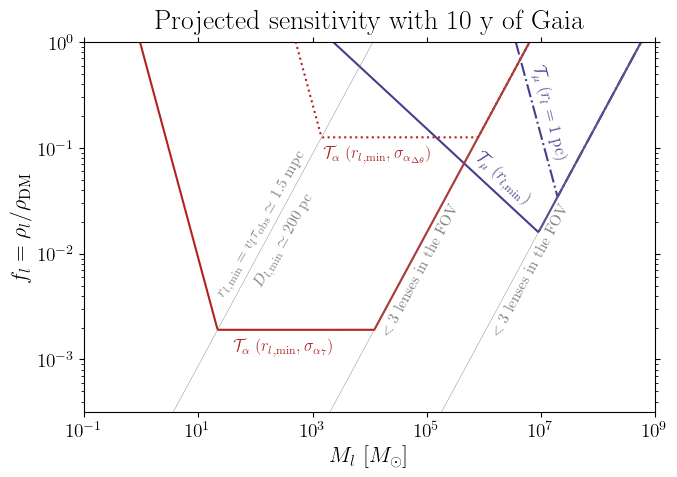

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['solid', '-.', ':']

ax.minorticks_on()
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both');

ax.plot(Ml_list/MSolar, fl_list_LMC_eom, c=colorlist[0], linewidth = 1.5, linestyle=liestyle_list[0])
ax.plot(Ml_list/MSolar, fl_fix_rl_list_LMC_eom, c=colorlist[0], linewidth = 1.5, linestyle=liestyle_list[1])
ax.plot(Ml_list_disk/MSolar, fl_list_disk_eom, c=colorlist[1], linewidth = 1.5, linestyle=liestyle_list[0])
ax.plot(Ml_list_disk/MSolar, fl_list_disk_hacky_eom, c=colorlist[1], linewidth = 1.5, linestyle=liestyle_list[2])

ax.plot(Ml_list/MSolar, fl_min_list_LMC, c='grey', linewidth = 0.3, linestyle='solid')
ax.plot(Ml_list_disk/MSolar, fl_max_list_disk_eom, c='grey', linewidth = 0.3, linestyle='solid')
ax.plot(Ml_list_disk/MSolar, fl_min_list_disk, c='grey', linewidth = 0.3, linestyle='solid')

#ax.contour(Ml_matrix/MSolar, fl_matrix, rl_min_matrix/pc, levels=[0.0018, 0.01], colors='k', linewidths = 0.5)
#ax.contour(Ml_matrix/MSolar, fl_matrix, Dl_min_matrix/kpc, levels=[0.2], colors='grey', linewidths = 0.3)

ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(0.1, 10**9); ax.set_ylim(10**(-3.5), 1); 

ax.set_title(r'Projected sensitivity with 10 y of Gaia', pad=10, fontsize=20);
ax.set_xlabel(r'$M_l\ [M_\odot]$ ', fontsize=16); 
#ax.set_ylabel(r'$f_l = \Omega_l/\Omega_\mathrm{DM}$ ', fontsize=16);
ax.set_ylabel(r'$f_l = \rho_l/\rho_\mathrm{DM}$ ', fontsize=16);
ax.text(6E5, 0.03, r'$\mathcal{T}_\mu\ (r_{l, \mathrm{min}})$', rotation=-43, c=colorlist[0], fontsize=12);
ax.text(6E6, 0.08, r'$\mathcal{T}_\mu\ (r_l = 1\ \mathrm{pc})$', rotation=-76, c=colorlist[0], fontsize=12);
ax.text(40, 0.0012, r'$\mathcal{T}_\alpha\ (r_{l, \mathrm{min}}, \sigma_{\alpha_7})$', c=colorlist[1], fontsize=12);
ax.text(1.5E3, 0.08, r'$\mathcal{T}_\alpha\ (r_{l, \mathrm{min}}, \sigma_{\alpha_{\Delta\theta}})$', c=colorlist[1], fontsize=12);
ax.text(20, 0.004, r'$ r_{l, \mathrm{min}} = v_l \tau_\mathrm{obs} \simeq 1.5\ \mathrm{mpc}$', rotation=60.5,  c='grey', fontsize=11);
ax.text(90, 0.005, r'$ D_{l, \mathrm{min}} \simeq 200\ \mathrm{pc}$', rotation=60.5,  c='grey', fontsize=11);
ax.text(1.5*10**4, 0.0017, r'$< 3$ lenses in the FOV', rotation=62,  c='grey', fontsize=11);
ax.text(1.3*10**6, 0.0017, r'$< 3$ lenses in the FOV', rotation=62,  c='grey', fontsize=11);

fig.tight_layout()
fig.savefig(FigDir+'Template_projections.pdf')

# chi^2 histograms

In [143]:
chi_sq_column = 'min_chi_sq' ### Choose which chi^2 to use, can be 'min_chi_sq' or 'min_chi_sq_mu_only'

In [146]:
param_space_points_00[1]

array(['62', '00', '34'], dtype='<U2')

In [147]:
p = param_space_points_00[0]
print(p)
xmin, xmax, nbins = -150, -30, 30
chisq_bins = np.arange(xmin, xmax, (xmax-xmin)/nbins)

sim_chisq = []; data_chisq = []; sim_90CL = []; sim_50CL = [];
sim_chisq_histo, sim_chisq_edges = np.zeros((len(data_file_names)+1, len(chisq_bins)-1)), np.zeros((len(data_file_names)+1, len(chisq_bins)))

for dfn_i, data_file_name in enumerate(data_file_names):
    sim_file = ListResDir+data_file_name+'_'+str(p[0])+'_'+str(p[1])+'_'+str(p[2])+'_all.csv'
    data_file = ListDataChiSq+data_file_name+'_chisq_'+str(p[0])+'_'+str(p[1])+'_'+str(p[2])+'.csv'

    if (os.path.isfile(sim_file) & os.path.isfile(data_file)):
        df_sim = pd.read_csv(sim_file)
        df_data = pd.read_csv(data_file)
        
        sim_chisq_histo[dfn_i], sim_chisq_edges[dfn_i] = np.histogram(df_sim[chi_sq_column].to_numpy(), bins=chisq_bins, density=True)
        data_chisq.extend(df_data[chi_sq_column].to_numpy())
        sim_chisq.append(df_sim[chi_sq_column].to_numpy())
        sim_90CL.append(np.percentile(df_sim[chi_sq_column].to_numpy(), 90))
        sim_50CL.append(np.percentile(df_sim[chi_sq_column].to_numpy(), 50))
        
if len(sim_chisq)>0:            
    ### The two lists might not have the same lenght because some simulations might go wrong. Uniform the length to the maximum number of simulations.
    #max_n_sim = min([len(sim_chisq_list) for sim_chisq_list in sim_chisq])
    #print(max_n_sim)
    #sim_chisq_array = np.zeros((max_n_sim, len(data_file_names)))    
    #for n_sim in range(len(sim_chisq)):
    #    sim_chisq_array[:, n_sim] = sim_chisq[n_sim][:max_n_sim]

    sim_chisq_histo[2], sim_chisq_edges[2] = np.histogram(np.min(np.array(sim_chisq).T, axis=1), bins=chisq_bins, density=True)
    sim_90CL.append(np.percentile(np.min(np.array(sim_chisq).T, axis=1), 90))
    sim_50CL.append(np.percentile(np.min(np.array(sim_chisq).T, axis=1), 50))
    data_chisq.append(min(data_chisq))   

['62' '00' '32']


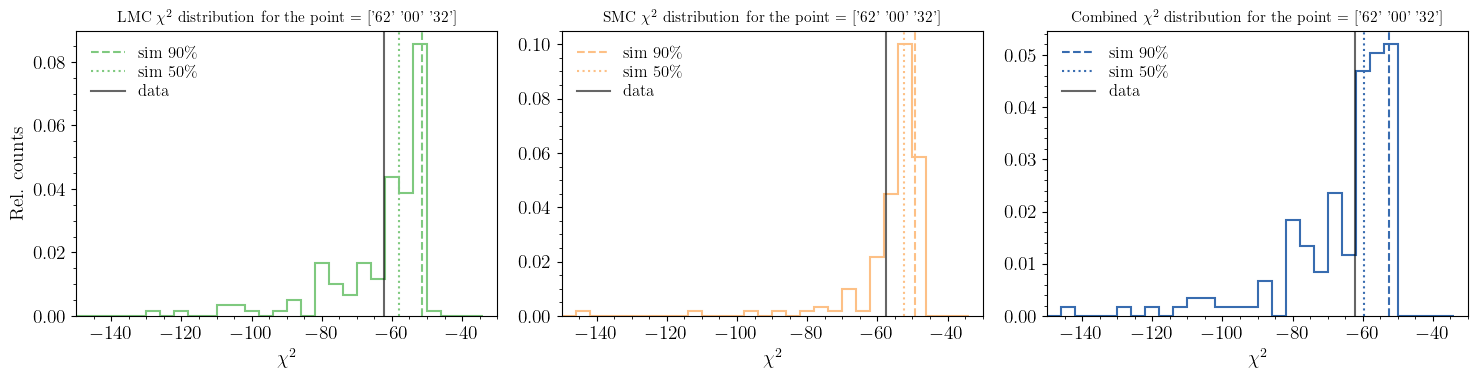

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
cmap = plt.get_cmap('Accent', 5)
colorlist = [cmap(0), cmap(1), cmap(2)]
linestylelist = ['--', ':', '-']
titlelist = [r'LMC $\chi^2$ distribution for the point = '+str(p), r'SMC $\chi^2$ distribution for the point = '+str(p), r'Combined $\chi^2$ distribution for the point = '+str(p)]

#pl = [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle=linestylelist[ii], color=colorlist[i])[0] for ii in range(2)] + [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle='-', color='k', alpha=0.6)[0] for i in range(3)] 


for i in range(len(data_file_names)+1):
    ax[i].minorticks_on()
    ax[i].hist(sim_chisq_edges[i][:-1], bins=sim_chisq_edges[i], histtype='step', weights=sim_chisq_histo[i], linewidth=1.5, color=cmap(i));
    ax[i].axvline(x=sim_90CL[i], color=colorlist[i], linestyle=linestylelist[0])
    ax[i].axvline(x=sim_50CL[i], color=colorlist[i], linestyle=linestylelist[1])
    ax[i].axvline(x=data_chisq[i], color='k', linestyle=linestylelist[2], alpha=0.6)
    ax[i].set_title(titlelist[i], fontsize=11);
    pl = [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle=linestylelist[ii], color=colorlist[i])[0] for ii in range(2)] + [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle='-', color='k', alpha=0.6)[0] for i in range(3)] 
    ax[i].set_xlim(xmin, xmax); ax[i].set_xlabel(r'$\chi^2$ ');
    ax[i].legend(pl, [r'sim $90\%$', r'sim $50\%$', r'data'], loc='upper left', fontsize = 12, frameon=False, labelspacing=0.2);
    [pl[i].set_visible(False) for i in range(len(pl))]

    
ax[0].set_ylabel(r'Rel. counts'); 
    
fig.tight_layout()
#fig.savefig(FigDir+'chisq_dist.pdf')

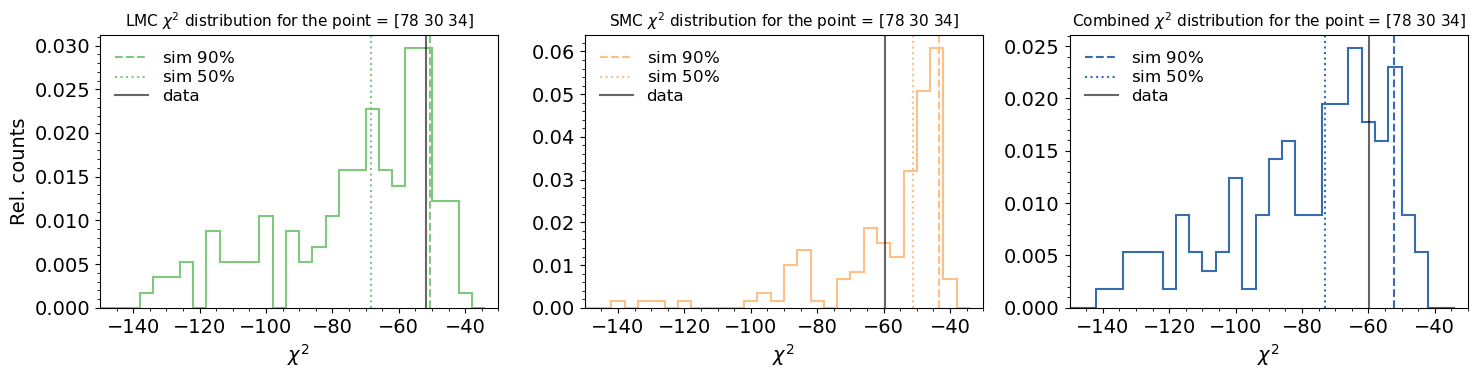

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
cmap = plt.get_cmap('Accent', 5)
colorlist = [cmap(0), cmap(1), cmap(2)]
linestylelist = ['--', ':', '-']
titlelist = [r'LMC $\chi^2$ distribution for the point = '+str(p), r'SMC $\chi^2$ distribution for the point = '+str(p), r'Combined $\chi^2$ distribution for the point = '+str(p)]

#pl = [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle=linestylelist[ii], color=colorlist[i])[0] for ii in range(2)] + [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle='-', color='k', alpha=0.6)[0] for i in range(3)] 


for i in range(len(data_file_names)+1):
    ax[i].minorticks_on()
    ax[i].hist(sim_chisq_edges[i][:-1], bins=sim_chisq_edges[i], histtype='step', weights=sim_chisq_histo[i], linewidth=1.5, color=cmap(i));
    ax[i].axvline(x=sim_90CL[i], color=colorlist[i], linestyle=linestylelist[0])
    ax[i].axvline(x=sim_50CL[i], color=colorlist[i], linestyle=linestylelist[1])
    ax[i].axvline(x=data_chisq[i], color='k', linestyle=linestylelist[2], alpha=0.6)
    ax[i].set_title(titlelist[i], fontsize=11);
    pl = [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle=linestylelist[ii], color=colorlist[i])[0] for ii in range(2)] + [plt.plot([0, xmax], [0, 0], linewidth=1.5, linestyle='-', color='k', alpha=0.6)[0] for i in range(3)] 
    ax[i].set_xlim(xmin, xmax); ax[i].set_xlabel(r'$\chi^2$ ');
    ax[i].legend(pl, [r'sim $90\%$', r'sim $50\%$', r'data'], loc='upper left', fontsize = 12, frameon=False, labelspacing=0.2);
    [pl[i].set_visible(False) for i in range(len(pl))]

    
ax[0].set_ylabel(r'Rel. counts'); 
    
fig.tight_layout()
#fig.savefig(FigDir+'chisq_dist.pdf')